# Nearest neighbor graph hybrid exploration

In [190]:
%env PYTHONHASHSEED=0

from IPython.lib.deepreload import reload

%load_ext autoreload
%autoreload 2

env: PYTHONHASHSEED=0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:

import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

from tv_show_recommender.pipelines import get_basic_nn_pipeline

np.random.seed(42)

show_id    user_id  rating    primary_title  start_year end_year  \
160700  19854762   48134010       1           Hijack        2023     2023   
8280     1236246   33704671      10         Runaways        2017     2019   
135037   9077540    3589319       7  Sweet Magnolias        2020       \N   
76913    5555260  163393781      10       This Is Us        2016     2022   
380662   5164196   94117410       8    Lethal Weapon        2016     2019   

                      genres  average_rating  num_votes  
160700        Drama,Thriller             7.4      59083  
8280     Action,Drama,Sci-Fi             6.9      27952  
135037         Drama,Romance             7.3      23751  
76913   Comedy,Drama,Romance             8.7     153701  
380662   Action,Comedy,Crime             7.8      39808

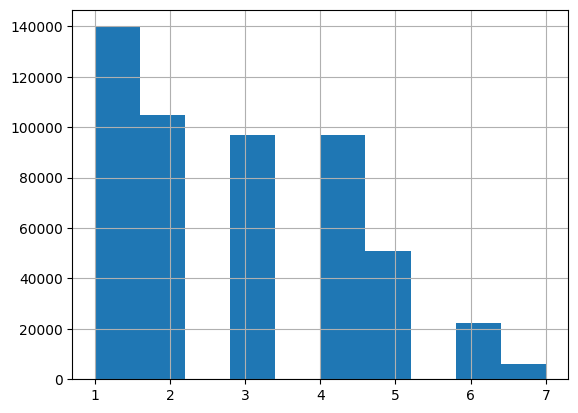

In [192]:

from tv_show_recommender.data.functions import get_stratified_data, get_show_data

show_data_df = get_show_data()
train_set, test_set = get_stratified_data()

train_set.head()

In [193]:
from tv_show_recommender.pipelines import get_high_quality_nn_pipeline

pipeline = get_high_quality_nn_pipeline()
data = pipeline.fit_transform(train_set)

data.head()

/Users/mav/code/personal/tv_show_recommender/tv_show_recommender/transformers.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["is_liked"] = (X["rating"] >= 8).astype(int)


show_id    user_id  is_liked
160700  19854762   48134010         0
135037   9077540    3589319         0
76913    5555260  163393781         1
380662   5164196   94117410         1
358821  20723374   33053487         1

In [194]:
show_user_df = data.pivot(index='user_id', columns='show_id', values='is_liked').fillna(0)
show_user_df.head()

show_id  43208     47708     50051     52520     53479     53488     53502     \
user_id                                                                         
11            0.0       0.0       0.0       0.0       0.0       0.0       0.0   
39            0.0       0.0       0.0       0.0       0.0       0.0       0.0   
436           0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1414          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2043          0.0       0.0       0.0       0.0       0.0       0.0       0.0   

show_id  54533     55683     56751     ...  21279678  21344706  22014226  \
user_id                                ...                                 
11            0.0       0.0       0.0  ...       0.0       0.0       0.0   
39            0.0       0.0       0.0  ...       0.0       0.0       0.0   
436           0.0       0.0       0.0  ...       0.0       0.0       0.0   
1414          0.0       0.0       0.0  ...       0.0       0.0       0.0   
2043          0.0       0.0       0.0  ...       0.0       0.0       0.0   

show_id  22074164  22185582  22297578  22373148  23037654  28227737  28857177  
user_id                                                                        
11            0.0       0.0       0.0       0.0       0.0       0.0       0.0  
39            0.0       0.0       0.0       0.0       0.0       0.0       0.0  
436           0.0       0.0       0.0       0.0       0.0       0.0       0.0  
1414          0.0       0.0       0.0       0.0       0.0       0.0       0.0  
2043          0.0       0.0       0.0       0.0       0.0       0.0       0.0  

[5 rows x 1458 columns]

In [195]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(show_user_df.T)

similarities = knn.kneighbors(show_user_df.T, return_distance=False)

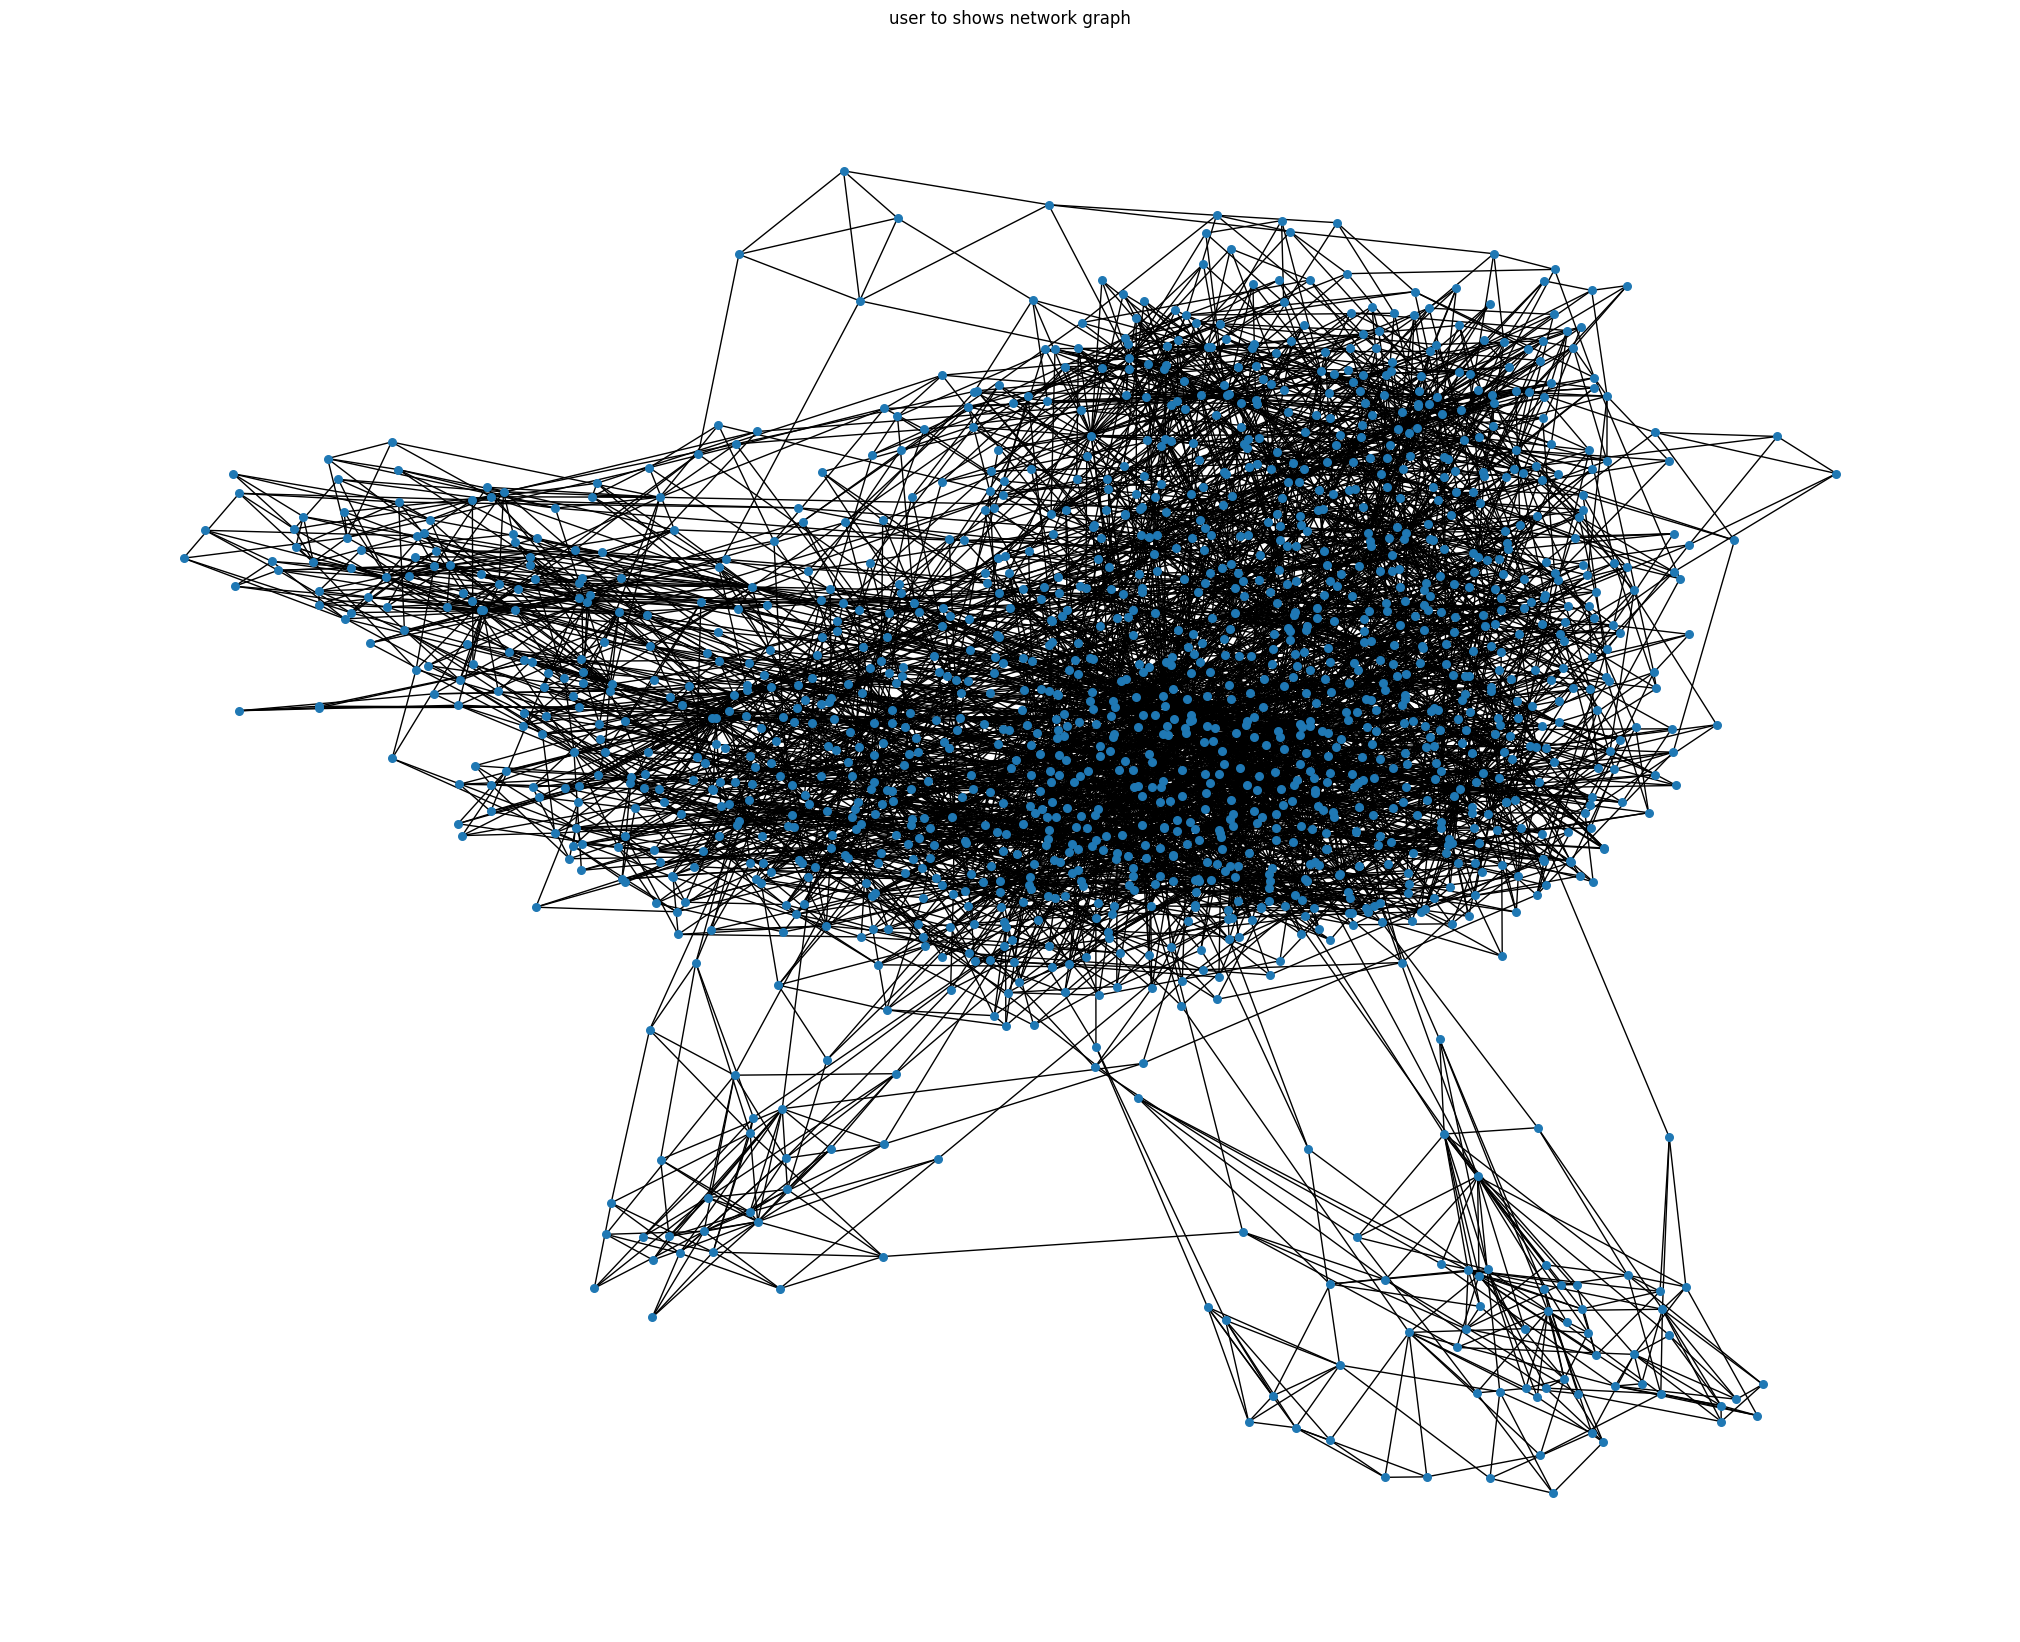

In [196]:
# What about a network graph?
G = nx.Graph()

# Add nodes to the graph
for i in range(len(show_user_df.T)):
    G.add_node(i)  # Each node represents an item/user

# Add edges based on similarities
for i, neighbors in enumerate(similarities):
    for neighbor in neighbors[1:]:  # Skip the first neighbor as it's itself
        G.add_edge(i, neighbor, weight=1)

# Visualize the network graph
plt.figure(figsize=(20, 16))
pos = nx.spring_layout(G)  # Layout algorithm to position nodes
nx.draw(G, pos, with_labels=False, node_size=30)
plt.title('user to shows network graph')
plt.show()

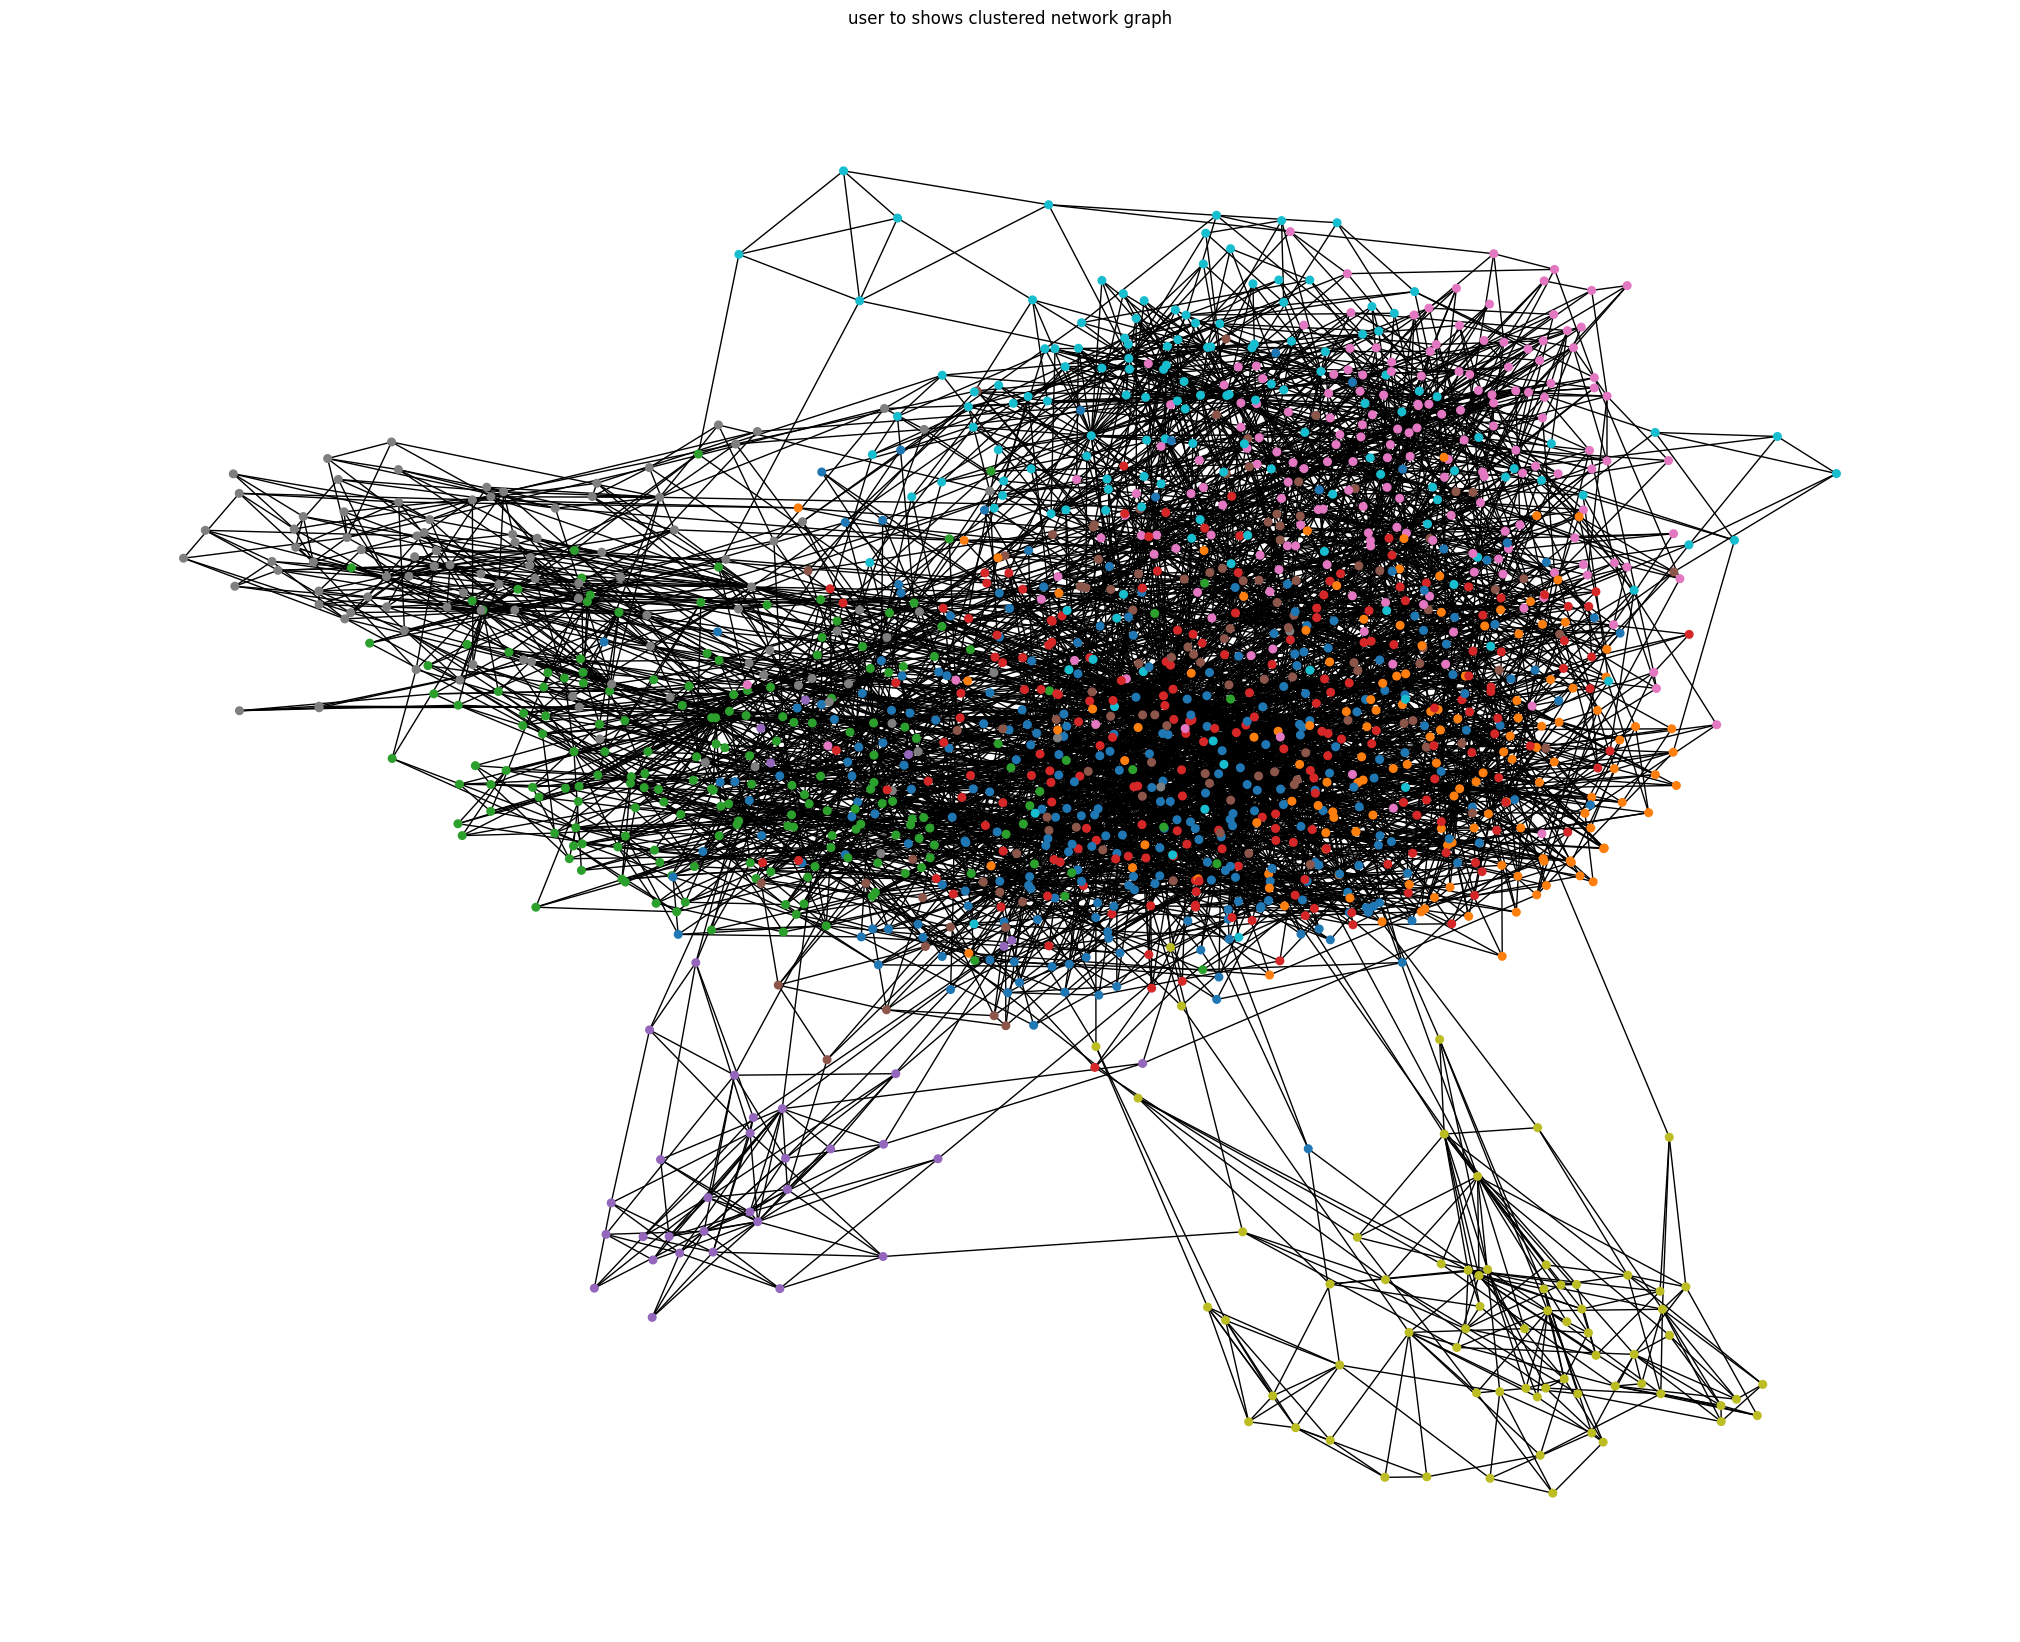

In [197]:
# How about a clustered network graph?
import community
import matplotlib.cm as cm

# Compute the best partition using the Louvain algorithm
partition = community.best_partition(G)

# Assign cluster information to nodes
for node, cluster_id in partition.items():
    G.nodes[node]['cluster'] = cluster_id
    G.nodes[node]['show_index'] = node

# Visualize the clustered network graph
plt.figure(figsize=(20, 16))
pos = nx.spring_layout(G, seed=42)

# Assign colors to nodes based on their clusters
node_colors = [cm.tab10(partition[node]) for node in G.nodes()]
nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=30)
plt.title('user to shows clustered network graph')
plt.show()

In [198]:
graph = G

show_id = 306414

# What partition does this show belong to?
show_idx = show_user_df.columns.get_loc(show_id)

print(show_idx)

partition_id = partition[show_idx]

print(partition_id)

partition_shows = [node for node, part_id in partition.items() if part_id == partition_id]

print(partition_shows)

265
5
[19, 39, 68, 78, 95, 151, 152, 155, 181, 189, 232, 239, 265, 275, 297, 336, 364, 372, 385, 390, 393, 400, 408, 412, 434, 476, 507, 524, 531, 534, 559, 565, 583, 591, 593, 606, 609, 628, 631, 636, 665, 666, 668, 699, 750, 758, 761, 786, 789, 819, 824, 830, 839, 865, 867, 881, 882, 887, 898, 911, 913, 916, 931, 933, 940, 989, 995, 998, 1024, 1028, 1031, 1040, 1051, 1055, 1057, 1063, 1069, 1070, 1072, 1084, 1086, 1091, 1094, 1101, 1122, 1142, 1144, 1154, 1161, 1206, 1213, 1225, 1226, 1227, 1270, 1272, 1273, 1279, 1281, 1290, 1295, 1302, 1313, 1317, 1336, 1337, 1351, 1352, 1384, 1408]


In [199]:
from tv_show_recommender.predictors import predict_nearest_neighbor

show_data_df = get_show_data()

def calc_start_year_distance(show_start_year, row_start_year):
    distance = abs(show_start_year - row_start_year)
    rank = 1 / (distance + 1)
    return rank

def calculate_genre_similarity(show_genres, row_genres):
    list_a = show_genres.split(',')
    list_b = row_genres.split(',')
    set_a = set(list_a)
    set_b = set(list_b)
    matching_genres = set_a.intersection(set_b)
    similarity_score = len(matching_genres) / max(len(set_a), len(set_b))
    return similarity_score

def calculate_rating_score(row_avg_rating, row_num_votes):
    rating_scaling_factor = 2.0
    votes_scaling_factor = 0.5

    scaled_rating = row_avg_rating ** rating_scaling_factor

    max_scaled_rating = (10 ** rating_scaling_factor)
    normalized_scaled_rating = scaled_rating / max_scaled_rating

    scaled_votes = row_num_votes ** votes_scaling_factor

    max_scaled_votes = (200000 ** votes_scaling_factor)
    normalized_scaled_votes = scaled_votes / max_scaled_votes

    score = (normalized_scaled_rating + normalized_scaled_votes) / 2.0
    return score

def calculate_weighted_ranking(row):
    weight_rating = 0.8
    weight_start_year = 0.1
    weight_genre = 0.1

    start_year_rank = row['start_year_rank']
    rating_rank = row['rating_rank']
    genre_rank = row['genres_rank']

    weighted_ranking = (start_year_rank * weight_start_year) + (genre_rank * weight_genre) + (rating_rank * weight_rating)

    return weighted_ranking


def top_ranked_show(show_id, potential_recommendation_show_ids, show_metadata_df):
    df = show_metadata_df[show_metadata_df['show_id'].isin(potential_recommendation_show_ids)]

    show_metadata_id = show_metadata_df[show_metadata_df['show_id'] == show_id].index.tolist()[0]
    show_metadata = show_metadata_df.iloc[show_metadata_id].to_dict()
    show_start_year = show_metadata['start_year']
    show_genre = show_metadata['genres']

    df['start_year_rank'] = df.apply(lambda row: calc_start_year_distance(show_start_year, row['start_year']), axis=1)
    df['genres_rank'] = df.apply(lambda row: calculate_genre_similarity(show_genre, row['genres']), axis=1)
    df['rating_rank'] = df.apply(lambda row: calculate_rating_score(row['average_rating'], row['num_votes']), axis=1)
    df['overall_ranking'] = df.apply(lambda row: calculate_weighted_ranking(row), axis=1)

    best_shows = df.sort_values(by=['overall_ranking'], ascending=[False])
    best_show_id = best_shows.iloc[0]['show_id']

    return best_show_id


def get_hybrid_recommendations(liked_shows, nn_model, nn_dataframe, show_metadata_df, partition):
    # retrieve nearest neighbor(s) recommendation
    nn_recs = predict_nearest_neighbor(liked_shows, model=nn_model, df=nn_dataframe)[:2]
    partition_recs = []

    # map each nearest neighbor to their partition
    partitions = []
    for nn_rec in nn_recs:
        show_idx = nn_dataframe.columns.get_loc(nn_rec)
        partition_id = partition[show_idx]
        partitions.append(partition_id)

    # Remove duplicates
    partitions = list(set(partitions))

    # include relevant shows from cluster
    partition_show_ids = []
    for partition_id in partitions:
        partition_shows = [node for node, part_id in partition.items() if part_id == partition_id]
        partition_shows_idx = [x for x in partition_shows if x not in liked_shows]
        this_partition_show_ids = list(set(show_metadata_df.iloc[partition_shows_idx]['show_id']))
        partition_show_ids = list(set(partition_show_ids + this_partition_show_ids))

    for show_id in liked_shows:
        top_show = top_ranked_show(show_id, partition_show_ids, show_metadata_df)
        partition_recs.append(top_show)

    return list(set(nn_recs + partition_recs))


# The Wire, DS9, The Sopranos
liked_shows = [306414, 141842, 979432]

recs = get_hybrid_recommendations(liked_shows, nn_model=knn, nn_dataframe=show_user_df, show_metadata_df=show_data_df, partition=partition)

print(recs)


# TODO: measure against NN baseline

[460627, 903747, 2071645]


/var/folders/0p/jtbnm2_n28v73m_gyzk0grxw0000gn/T/ipykernel_57113/2026172634.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_year_rank'] = df.apply(lambda row: calc_start_year_distance(show_start_year, row['start_year']), axis=1)
/var/folders/0p/jtbnm2_n28v73m_gyzk0grxw0000gn/T/ipykernel_57113/2026172634.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genres_rank'] = df.apply(lambda row: calculate_genre_similarity(show_genre, row['genres']), axis=1)
/var/folders/0p/jtbnm2_n28v73m_gyzk

In [ ]:
import pandas as pd

test_data_prepared = pipeline.fit_transform(test_set)
test_data_processed = test_data_prepared.drop_duplicates(subset=['user_id', 'show_id'])
test_show_user_df = test_data_processed.pivot(index='user_id', columns='show_id', values='is_liked').fillna(0)

# Pad the test data to have an equal # of users and shows
difference = len(show_user_df) - len(test_show_user_df)
missing_user_ids = [0] * difference
padded_rows = pd.DataFrame(0, columns=test_show_user_df.columns, index=missing_user_ids)
padded_rows['user_id'] = missing_user_ids
test_show_user_df = pd.concat([test_show_user_df, padded_rows.set_index('user_id')])

missing_columns = show_user_df.columns.difference(test_show_user_df.columns)

for column in missing_columns:
    test_show_user_df[column] = 0

test_show_user_df = test_show_user_df.copy()


def is_user_in_both_sets(user_id):
    if user_id in show_user_df.index and user_id in test_show_user_df.index:
        return True

    return False

def get_user_liked_shows_from_test(user_id):
     return test_show_user_df.columns[test_show_user_df.loc[user_id] == 1].tolist()

def get_user_liked_shows_from_train(user_id):
    return show_user_df.columns[show_user_df.loc[user_id] == 1].tolist()

def precision_at_k(actual_liked_items, recommended_items, k):
    recommended_items_cross_section = []

    for actual_liked_item in actual_liked_items:
        if actual_liked_item in recommended_items:
            recommended_items_cross_section.append(actual_liked_item)
        else:
            recommended_items_cross_section.append(0)

    num_relevant_recommendations = len(set(actual_liked_items) & set(recommended_items_cross_section))

    precision = num_relevant_recommendations / k if k > 0 else 0
    return precision


precision_scores = []

at_least_3_liked_shows = test_show_user_df[test_show_user_df.eq(1.0).sum(axis=1) >= 3]

for user_id, df in at_least_3_liked_shows.groupby("user_id"):
    if not is_user_in_both_sets(user_id):
        continue

    test_user_liked_shows = get_user_liked_shows_from_test(user_id)

    if len(test_user_liked_shows) == 0:
        continue

    actual_user_liked_shows = get_user_liked_shows_from_train(user_id)
    recommended_shows = get_hybrid_recommendations(test_user_liked_shows, nn_model=knn, nn_dataframe=test_show_user_df, show_metadata_df=show_data_df, partition=partition)

    precision_score = precision_at_k(actual_user_liked_shows, recommended_shows, 1)
    precision_scores.append(precision_score)

mean_precision = np.mean(precision_scores)

print("Mean Precision:", mean_precision)

/Users/mav/code/personal/tv_show_recommender/tv_show_recommender/transformers.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["is_liked"] = (X["rating"] >= 8).astype(int)
/var/folders/0p/jtbnm2_n28v73m_gyzk0grxw0000gn/T/ipykernel_57113/2146972325.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_show_user_df[column] = 0
/var/folders/0p/jtbnm2_n28v73m_gyzk0grxw0000gn/T/ipykernel_57113/2026172634.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .